In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
from wordcloud import WordCloud
import seaborn as sns
from io import StringIO
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    print_line()
    print("File is read")
    print_line()
    return text

def converting_string_todf(data):
    # Convert string to file-like object
    file_obj = StringIO(data)
    # Read file-like object into a DataFrame
    df = pd.read_csv(file_obj,delimiter='\t',header=None)
    df.columns = ['English','Spanish','Source']
    df.drop('Source',axis=1,inplace=True)
    df1 = df.copy()
    print(df.head())
    return df,df1

def english_wordcloud(df):
    print("Visulization Of Most Common English Word: ")
    print()
    wc = WordCloud(width=600,height=300).generate(' '.join(df.English))
    plt.imshow(wc);
    
def Spanish_wordcloud(df):
    print("Visulization Of Most Common Spanish Word: ")
    wc = WordCloud(width=600,height=300).generate(' '.join(df.Spanish))
    plt.imshow(wc);
    
def Visulization(df):
    print("Shape of Data Frame: ",df.shape)
    print_add()
    print("To check For NULL Values: ")
    print(df.isna().sum())
    print_add()
    print()
    print("To Check for any Duplicate value: ", df.duplicated().sum())
    print()
    print(df.describe())
    print_add()
    print()
    df['eng_len'] = df.English.apply(len)
    df['spa_len'] = df.Spanish.apply(len)
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,9))
    sns.histplot(df.eng_len,ax=axes[0],color ="red")
    sns.histplot(df.spa_len,ax=axes[1],color ="red")
    print(df.describe())

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    lines = [i.split('\t') for i in sents]
    # Conver into Array
    lines = array(lines)
    # Taking only 100000
    lines = lines[:100000,:] 
    print("Keeping Dataset Size-due to ristruction: ",len(lines))
    print("")
    print_line()
    print()
    return lines

def print_line():
    print(u'\u2550' * 50) 
    
def print_add():
    print('+' * 50)
    
def prepreocess(spa_eng):
    # Remove punctuation
    spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
    spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]
     # convert to lowercase
    for i in range(len(spa_eng)):
        # Converting English to Lower case
        spa_eng[i,0] = spa_eng[i,0].lower()
        # Converting Spanish to Lower case
        spa_eng[i,1] = spa_eng[i,1].lower()    
    return spa_eng
    
def preprocess_1(df1,spa_eng):
    clean = prepreocess(spa_eng)    
    print("Pre-process is intiated")
    print("1]. Punctuation is removed for both English and Spanish")
    print("2]. All leters converted for both English and Spanish")
    print_add()
    print("Before Preprocessing: ")
    print(df1.head())
    # Remove punctuation and convert to lowercase
    for i in range(len(df1)):
        df1.iloc[i,0] = df1.iloc[i,0].translate(str.maketrans('', '', string.punctuation)).lower()
        df1.iloc[i,1] = df1.iloc[i,1].translate(str.maketrans('', '', string.punctuation)).lower()
    print_add()
    print("After Preprocessing: ")
    print(df1.head())
    return clean

def plot_sentence_lengths(clean):
    # Create empty lists for sentence lengths
    eng_lengths = []
    spa_lengths = []
    # Populate the lists with sentence lengths
    for eng_sent, spa_sent in clean[:, :2]:
        eng_lengths.append(len(eng_sent.split()))
        spa_lengths.append(len(spa_sent.split()))
        
    # Create a pandas DataFrame with sentence lengths
    print_line()
    print("Create a pandas DataFrame with sentence lengths")
    print(" ")
    length_df = pd.DataFrame({'English': eng_lengths, 'Spanish': spa_lengths})
    print(length_df.head())
    print_add()
    print("Graph Representation")
    # Plot histograms of sentence lengths
    length_df.hist(bins=30, alpha=0.5, color = 'red')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.show()
    print_add()
    
    # Print unique sentence lengths
    print(f"Unique English sentence lengths: {np.unique(length_df['English'])}")
    print("")
    print(f"Unique Spanish sentence lengths: {np.unique(length_df['Spanish'])}")
    print_add()
    print("")
    a = np.max(length_df['English'])
    print(f"Maximum English sentence lengths: {a}")
    print("")
    print(f"Maximum Spanish sentence lengths: {np.max(length_df['Spanish'])}")
    print_line()
    print()
    return a


In [3]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# English tokenizer 
def prepare_english_tokenizer(spa_eng):
    print("Tokenization process has started: ")
    print_add()
    eng_tokenizer = tokenization(spa_eng[:, 0])
    # Print the English vocabulary size
    eng_size = len(eng_tokenizer.word_index) + 1
    print("Tokenizing English Word: ")
    print()
    print(f'English Vocabulary Size: {eng_size}')
    print("Tokenization of English word is completed.")    
    # Return the tokenizer object
    return eng_tokenizer, eng_size

# Spanish tokenizer
def prepare_spanish_tokenizer(spa_eng):
    print_add()
    spa_tokenizer = tokenization(spa_eng[:, 1])
    # Print the English vocabulary size
    spa_size = len(spa_tokenizer.word_index) + 1
    print("Tokenizing Spanish Word:")
    print()
    print(f'Spanish Vocabulary Size: {spa_size}')
    print("Tokenization of Spanish word is completed.")
    print_line()
    print()
    # Return the tokenizer object
    return spa_tokenizer, spa_size


In [4]:
# Split Dataset in 80:20
def split_dataset(spa_eng):
    train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)
    print("Dataset is slpited into test and train")
    return train, test

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

# Encoded Dataset
def encoded_data(maxi):    
    print("Encoding section")
    print_add()
    train, test = split_dataset(spa_eng)        
    eng_length = maxi
    spa_length = maxi
    print()
    # prepare training data
    trainX = encode_sequences(spanish_tokenizer, spa_length, train[:, 1])
    trainY = encode_sequences(english_tokenizer, eng_length, train[:, 0])
    print("Encodeing training data: trainX, trainY sucessfull")
    # prepare validation data
    testX = encode_sequences(spanish_tokenizer, spa_length, test[:, 1])
    testY = encode_sequences(english_tokenizer, eng_length, test[:, 0])
    print("Encodeing validation data: testX, testY sucessfull")
    print()
    print("Encoded data is sucefully geberated !!")
    print_line()
    return train, test, trainX, trainY, testX,testY 


In [5]:
# from keras.utils.vis_utils import plot_model
# import pydotplus
# from IPython.display import Image

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

# def plot_model_plus(model, file_path, show_shapes=True, show_layer_names=True):
#     plot_model(model, to_file=file_path, show_shapes=show_shapes, show_layer_names=show_layer_names)
#     print("Model Architecture saved at: ", file_path)
    
# Otimzation-Tuning
def optimization(spa_length, eng_length):
    print("Model:...")
    print_add()
    print("Model Summary: ")
    model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
#     plot_model_plus(model)
    print_add()
    rms = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer= rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


# model run
def comile_model(model):        
    filename = 'model.h1'
    checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')

    history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
              epochs=40, batch_size=512, 
              validation_split = 0.2,
              callbacks=[checkpoint], verbose=1)
    return history

def graph(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


In [6]:
# get pridection
def preds():
    print_add()
    model = load_model('model.h1')
    preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
    preds = np.argmax(preds, axis=-1)
    print_add()
    return preds

# tokenization to words
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# get pridected words
def get_pridectedwords():    
    pred_text = []
    for i in pred:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], english_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], english_tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t)   
        
        pred_text.append(' '.join(temp))  
    return  pred_text

In [7]:
def get_accuracy():     
    # define the maximum length of a sentence
    max_length = 10
    # convert predicted text to integer sequences
    preds_seq = []
    for i in preds_text:
        # split the text into words
        words = i.split()
        # truncate or pad the words to the maximum length
        words = words[:max_length] + [''] * (max_length - len(words))
        # convert words to integer sequences
        seq = english_tokenizer.texts_to_sequences([words])[0]
        preds_seq.append(seq)

    # pad sequences with zeros to make them all the same length
    preds_seq = pad_sequences(preds_seq, maxlen=max_length, padding='post', truncating='post')
    # convert sequences to one-hot encoded format
    preds_seq = preds_seq - 1
    preds_seq[preds_seq < 0] = 0
    # make predictions
    preds_seq = model.predict(testX)
    # calculate accuracy
    accuracy = accuracy_score(testY.reshape(testY.shape[0]*testY.shape[1]), 
                              argmax(preds_seq.reshape(preds_seq.shape[0]*preds_seq.shape[1], -1), axis=1))
    print_line()
    print("Accuracy : ",accuracy*100)
    print_line()
    
   


In [8]:
from nltk.translate.bleu_score import corpus_bleu

# Convert integer sequences back to text
def sequence_to_text(tokenizer, sequence):
    text = ''
    for i in sequence:
        if i != 0:
            word = get_word(i, tokenizer)
            if word is not None:
                text += word + ' '
    return text.strip()

def get_blueScore():
    
    # Convert sequences to text
    preds_text = []
    for i in pred:
        preds_text.append(sequence_to_text(english_tokenizer, i))
    testY_text = []
    for i in testY:
        testY_text.append(sequence_to_text(english_tokenizer, i))
    # Calculate BLEU score
    references = [[text.split()] for text in testY_text]
    hypotheses = [text.split() for text in preds_text]
    bleu_score = corpus_bleu(references, hypotheses)

    print_line()
    print('BLEU score:', bleu_score)
    print_line()



══════════════════════════════════════════════════
File is read
══════════════════════════════════════════════════
  English  Spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.
Shape of Data Frame:  (139013, 2)
++++++++++++++++++++++++++++++++++++++++++++++++++
To check For NULL Values: 
English    0
Spanish    0
dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++

To Check for any Duplicate value:  0

                      English          Spanish
count                  139013           139013
unique                 118119           130714
top     You can put it there.  Estoy quebrado.
freq                       68               12
++++++++++++++++++++++++++++++++++++++++++++++++++

             eng_len        spa_len
count  139013.000000  139013.000000
mean       31.203938      32.574033
std        13.201240      14.523757
min         3.000000       3.000000
25%        22.000000      23.000000
50%        29.000000      3

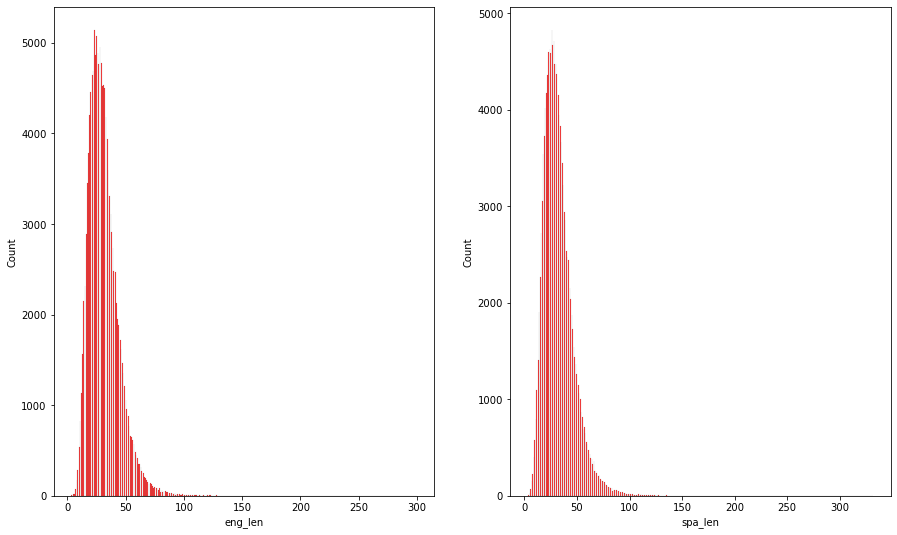

In [9]:
%%time
# Read data
data = read_text("spa.txt")
df,df1 = converting_string_todf(data)
Visulization(df)
print()

Visulization Of Most Common English Word: 



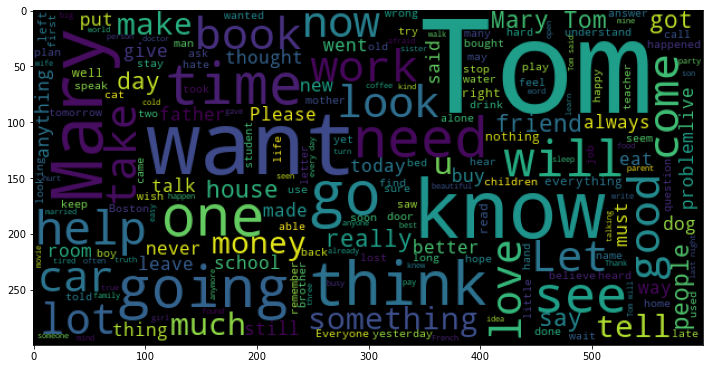

In [10]:
english_wordcloud(df)


Visulization Of Most Common Spanish Word: 


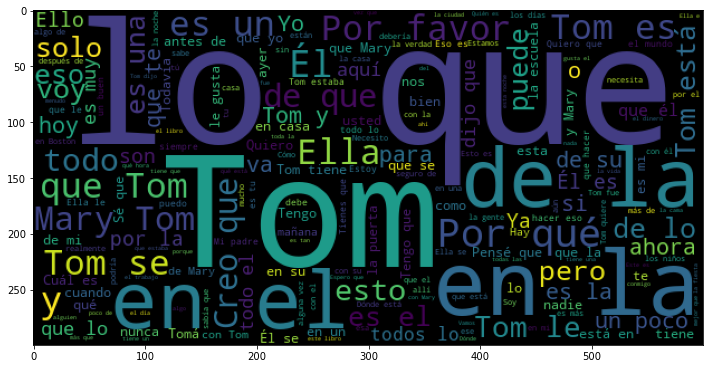

In [11]:
Spanish_wordcloud(df)

In [12]:
%%time
# Convert into lines and array
spa_eng = to_lines(data)
# preprocess
clean = preprocess_1(df1,spa_eng)
print()


Keeping Dataset Size-due to ristruction:  100000

══════════════════════════════════════════════════

Pre-process is intiated
1]. Punctuation is removed for both English and Spanish
2]. All leters converted for both English and Spanish
++++++++++++++++++++++++++++++++++++++++++++++++++
Before Preprocessing: 
  English  Spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.
++++++++++++++++++++++++++++++++++++++++++++++++++
After Preprocessing: 
  English Spanish
0      go      ve
1      go    vete
2      go    vaya
3      go  váyase
4      hi    hola

CPU times: total: 3.03 s
Wall time: 10.2 s


══════════════════════════════════════════════════
Create a pandas DataFrame with sentence lengths
 
   English  Spanish
0        1        1
1        1        1
2        1        1
3        1        1
4        1        1
++++++++++++++++++++++++++++++++++++++++++++++++++
Graph Representation


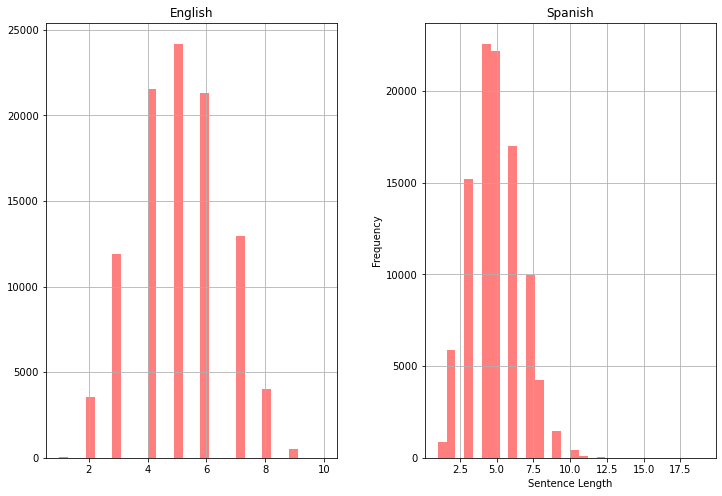

++++++++++++++++++++++++++++++++++++++++++++++++++
Unique English sentence lengths: [ 1  2  3  4  5  6  7  8  9 10]

Unique Spanish sentence lengths: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 19]
++++++++++++++++++++++++++++++++++++++++++++++++++

Maximum English sentence lengths: 10

Maximum Spanish sentence lengths: 19
══════════════════════════════════════════════════

Tokenization process has started: 
++++++++++++++++++++++++++++++++++++++++++++++++++
Tokenizing English Word: 

English Vocabulary Size: 10643
Tokenization of English word is completed.
++++++++++++++++++++++++++++++++++++++++++++++++++
Tokenizing Spanish Word:

Spanish Vocabulary Size: 21744
Tokenization of Spanish word is completed.
══════════════════════════════════════════════════

Encoding section
++++++++++++++++++++++++++++++++++++++++++++++++++
Dataset is slpited into test and train

Encodeing training data: trainX, trainY sucessfull
Encodeing validation data: testX, testY sucessfull

Encoded data is suce

In [13]:
%%time
# get maximum valu os eng seentence
maxi = plot_sentence_lengths(clean)
spa_eng=clean
#Tokenization
english_tokenizer, eng_vocab_size = prepare_english_tokenizer(spa_eng)
spanish_tokenizer, spa_vocab_size = prepare_spanish_tokenizer(spa_eng)
# Split dataset , new dataset generation
train, test, trainX, trainY, testX, testY = encoded_data(maxi)

In [14]:
model = optimization(spa_length = 10, eng_length = 10)  

Model:...
++++++++++++++++++++++++++++++++++++++++++++++++++
Model Summary: 
++++++++++++++++++++++++++++++++++++++++++++++++++
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 512)           11132928  
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 10, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10, 512)           2099200   
                                                                 
 dense (Dense)               (None, 10, 10643)         5459859   
                                                            

In [15]:
%%time
# model fit 
history = comile_model(model) 
print()

Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 3.5827 - accuracy: 0.5126
Epoch 1: val_loss improved from inf to 3.16772, saving model to model.h1


125/125 [==============================] - 524s 4s/step - loss: 3.5827 - accuracy: 0.5126 - val_loss: 3.1677 - val_accuracy: 0.5263
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 3.0677 - accuracy: 0.5360
Epoch 2: val_loss improved from 3.16772 to 3.01763, saving model to model.h1


125/125 [==============================] - 571s 5s/step - loss: 3.0677 - accuracy: 0.5360 - val_loss: 3.0176 - val_accuracy: 0.5434
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 2.8951 - accuracy: 0.5515
Epoch 3: val_loss improved from 3.01763 to 2.82222, saving model to model.h1


125/125 [==============================] - 580s 5s/step - loss: 2.8951 - accuracy: 0.5515 - val_loss: 2.8222 - val_accuracy: 0.5633
Epoch 4/40
125/125 [==============================] - ETA: 0s - loss: 2.6867 - accuracy: 0.5749
Epoch 4: val_loss improved from 2.82222 to 2.63082, saving model to model.h1


125/125 [==============================] - 618s 5s/step - loss: 2.6867 - accuracy: 0.5749 - val_loss: 2.6308 - val_accuracy: 0.5840
Epoch 5/40
125/125 [==============================] - ETA: 0s - loss: 2.4808 - accuracy: 0.5960
Epoch 5: val_loss improved from 2.63082 to 2.46509, saving model to model.h1


125/125 [==============================] - 598s 5s/step - loss: 2.4808 - accuracy: 0.5960 - val_loss: 2.4651 - val_accuracy: 0.6049
Epoch 6/40
125/125 [==============================] - ETA: 0s - loss: 2.2943 - accuracy: 0.6181
Epoch 6: val_loss improved from 2.46509 to 2.31300, saving model to model.h1


125/125 [==============================] - 603s 5s/step - loss: 2.2943 - accuracy: 0.6181 - val_loss: 2.3130 - val_accuracy: 0.6260
Epoch 7/40
125/125 [==============================] - ETA: 0s - loss: 2.1213 - accuracy: 0.6381
Epoch 7: val_loss improved from 2.31300 to 2.18527, saving model to model.h1


125/125 [==============================] - 674s 5s/step - loss: 2.1213 - accuracy: 0.6381 - val_loss: 2.1853 - val_accuracy: 0.6409
Epoch 8/40
125/125 [==============================] - ETA: 0s - loss: 1.9667 - accuracy: 0.6552
Epoch 8: val_loss improved from 2.18527 to 2.07682, saving model to model.h1


125/125 [==============================] - 695s 6s/step - loss: 1.9667 - accuracy: 0.6552 - val_loss: 2.0768 - val_accuracy: 0.6536
Epoch 9/40
125/125 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.6710
Epoch 9: val_loss improved from 2.07682 to 1.97349, saving model to model.h1


125/125 [==============================] - 632s 5s/step - loss: 1.8247 - accuracy: 0.6710 - val_loss: 1.9735 - val_accuracy: 0.6673
Epoch 10/40
125/125 [==============================] - ETA: 0s - loss: 1.6925 - accuracy: 0.6858
Epoch 10: val_loss improved from 1.97349 to 1.89942, saving model to model.h1


125/125 [==============================] - 627s 5s/step - loss: 1.6925 - accuracy: 0.6858 - val_loss: 1.8994 - val_accuracy: 0.6760
Epoch 11/40
125/125 [==============================] - ETA: 0s - loss: 1.5718 - accuracy: 0.6999
Epoch 11: val_loss improved from 1.89942 to 1.81876, saving model to model.h1


125/125 [==============================] - 649s 5s/step - loss: 1.5718 - accuracy: 0.6999 - val_loss: 1.8188 - val_accuracy: 0.6840
Epoch 12/40
125/125 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.7136
Epoch 12: val_loss improved from 1.81876 to 1.78086, saving model to model.h1


125/125 [==============================] - 618s 5s/step - loss: 1.4594 - accuracy: 0.7136 - val_loss: 1.7809 - val_accuracy: 0.6900
Epoch 13/40
125/125 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.7276
Epoch 13: val_loss improved from 1.78086 to 1.71326, saving model to model.h1


125/125 [==============================] - 585s 5s/step - loss: 1.3563 - accuracy: 0.7276 - val_loss: 1.7133 - val_accuracy: 0.6994
Epoch 14/40
125/125 [==============================] - ETA: 0s - loss: 1.2590 - accuracy: 0.7408
Epoch 14: val_loss improved from 1.71326 to 1.69068, saving model to model.h1


125/125 [==============================] - 903s 7s/step - loss: 1.2590 - accuracy: 0.7408 - val_loss: 1.6907 - val_accuracy: 0.7033
Epoch 15/40
125/125 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.7555
Epoch 15: val_loss improved from 1.69068 to 1.66344, saving model to model.h1


125/125 [==============================] - 692s 6s/step - loss: 1.1674 - accuracy: 0.7555 - val_loss: 1.6634 - val_accuracy: 0.7086
Epoch 16/40
125/125 [==============================] - ETA: 0s - loss: 1.0841 - accuracy: 0.7682
Epoch 16: val_loss improved from 1.66344 to 1.59723, saving model to model.h1


125/125 [==============================] - 603s 5s/step - loss: 1.0841 - accuracy: 0.7682 - val_loss: 1.5972 - val_accuracy: 0.7149
Epoch 17/40
125/125 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.7808
Epoch 17: val_loss improved from 1.59723 to 1.57273, saving model to model.h1


125/125 [==============================] - 619s 5s/step - loss: 1.0081 - accuracy: 0.7808 - val_loss: 1.5727 - val_accuracy: 0.7193
Epoch 18/40
125/125 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.7932
Epoch 18: val_loss improved from 1.57273 to 1.57208, saving model to model.h1


125/125 [==============================] - 595s 5s/step - loss: 0.9358 - accuracy: 0.7932 - val_loss: 1.5721 - val_accuracy: 0.7225
Epoch 19/40
125/125 [==============================] - ETA: 0s - loss: 0.8662 - accuracy: 0.8061
Epoch 19: val_loss improved from 1.57208 to 1.54538, saving model to model.h1


125/125 [==============================] - 594s 5s/step - loss: 0.8662 - accuracy: 0.8061 - val_loss: 1.5454 - val_accuracy: 0.7260
Epoch 20/40
125/125 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.8179
Epoch 20: val_loss improved from 1.54538 to 1.53228, saving model to model.h1


125/125 [==============================] - 616s 5s/step - loss: 0.8038 - accuracy: 0.8179 - val_loss: 1.5323 - val_accuracy: 0.7285
Epoch 21/40
125/125 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.8294
Epoch 21: val_loss improved from 1.53228 to 1.52539, saving model to model.h1


125/125 [==============================] - 651s 5s/step - loss: 0.7450 - accuracy: 0.8294 - val_loss: 1.5254 - val_accuracy: 0.7295
Epoch 22/40
125/125 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.8404
Epoch 22: val_loss did not improve from 1.52539
125/125 [==============================] - 785s 6s/step - loss: 0.6904 - accuracy: 0.8404 - val_loss: 1.5277 - val_accuracy: 0.7313
Epoch 23/40
125/125 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.8514
Epoch 23: val_loss did not improve from 1.52539
125/125 [==============================] - 970s 8s/step - loss: 0.6377 - accuracy: 0.8514 - val_loss: 1.5261 - val_accuracy: 0.7308
Epoch 24/40
125/125 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.8620
Epoch 24: val_loss did not improve from 1.52539
125/125 [==============================] - 890s 5s/step - loss: 0.5879 - accuracy: 0.8620 - val_loss: 1.5278 - val_accuracy: 0.7324
Epoch 25/40
125/125 [================

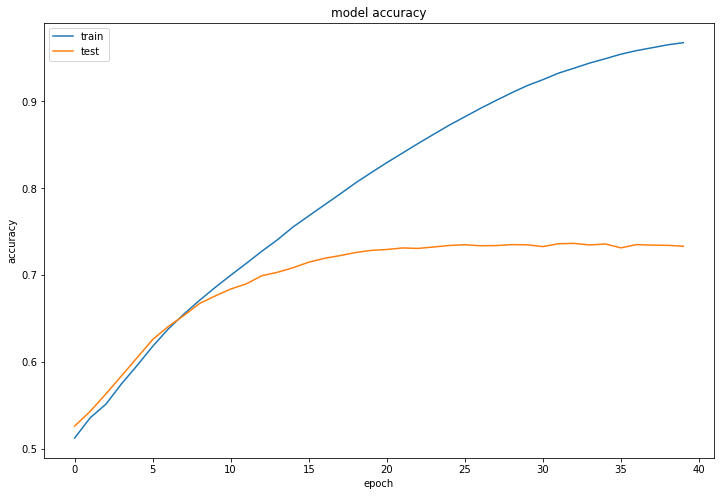

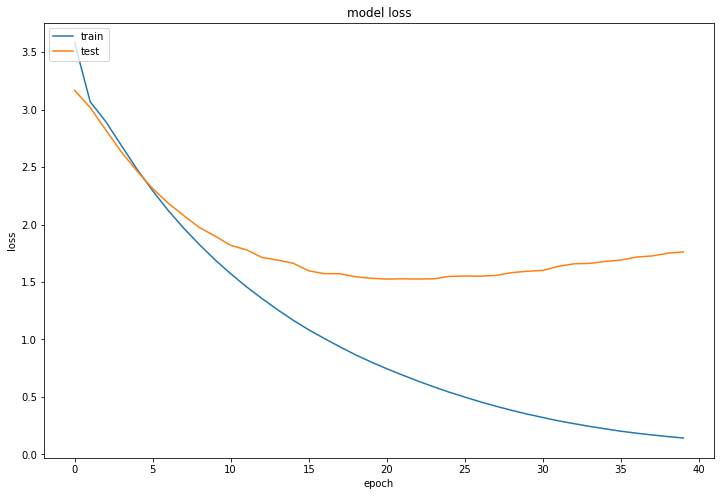

In [16]:
graph(history)

In [17]:
%%time
# pridection
pred = preds()
print()

++++++++++++++++++++++++++++++++++++++++++++++++++
625/625 [==============================] - 108s 169ms/step
++++++++++++++++++++++++++++++++++++++++++++++++++

CPU times: total: 5min 19s
Wall time: 4min 44s


In [18]:
%%time
# Converting sequence to text
preds_text = get_pridectedwords()
print()


CPU times: total: 3min 57s
Wall time: 10min 15s


In [19]:
%%time
# Accuracy
get_accuracy() 

# Blue Score
get_blueScore()

625/625 [==============================] - 101s 157ms/step
══════════════════════════════════════════════════
Accuracy :  73.1045
══════════════════════════════════════════════════
══════════════════════════════════════════════════
BLEU score: 0.25690668995208826
══════════════════════════════════════════════════
CPU times: total: 5min 14s
Wall time: 4min 57s


In [20]:
def create_pred_df(test, preds_text):
    # Create a DataFrame with actual and predicted values
    pred_df = pd.DataFrame({'Actual Spanish': test[:, 1],'Actual English': test[:, 0], 'Predicted': preds_text})
    return pred_df

pred_df = create_pred_df(test, preds_text)
pred_df.sample(15)
# printig random sample

,Actual Spanish,Actual English,Predicted
9264,a tom comenzó a temerle a mary,tom became afraid of mary,tom started to
7261,¿puedes enseñarme a volar,can you teach me how to fly,can you help me to
16473,nunca he vivido en el extranjero,ive never lived abroad,ive never traveled abroad
10105,tom enfrenta un dilema,tom faces a dilemma,tom drives a creep
12692,¿podemos ponerle llave a esta puerta,can we lock this door,can we use the door
4692,los marineros vieron tierra firme,the sailors saw land,the love found sound
5421,vivía en australia,i used to live in australia,he lived in
19634,no vimos esta película,we didnt see this movie,we didnt this movie
8897,quiero ahorrar más,i want to save more money,i want to ask more
6229,no puedo evitarlo más,i cant help myself anymore,i cant help you more


In [21]:
# Printing first head
pred_df.head(15)

,Actual Spanish,Actual English,Predicted
0,has trabajado hasta la extenuación,youve worked hard,youve arrived up last
1,su sombra en la pared parecía triste,his shadow on the wall looked sad,his poor in to his
2,él es mucho mejor que tú,he is much better than you,he is much better you
3,¿cómo puedo ayudar,how can i help,how can i help you
4,tom ya te ha olvidado,tom has already forgotten about you,tom already forgotten
5,nadie nos pidió nada,no one asked us anything,nobody one us anything
6,¿cúando acaba,when does it end,the doctor was come
7,creo que nos olvidamos de algo,i think we forgot something,i think we heard something
8,él no podía conseguir más dinero,he could get no more money,he couldnt not any
9,estoy trabajando,im working,im working


In [22]:
#printing bottom 15
pred_df.tail(15)

,Actual Spanish,Actual English,Predicted
19985,la guerra civil en grecia terminó,the civil war in greece ended,war went in mountains
19986,mi amigo solo come comida orgánica,my friend only eats organic food,my friend seems better food
19987,¿tienes novia allá en tu rancho,do you have a girlfriend back home,do you have a in
19988,de repente se puso a llover,suddenly it began to rain,suddenly raining
19989,no quieren que trabajemos juntas,they dont want us working together,they dont want to here
19990,tom murió hace un par de años,tom died a couple of years ago,tom died a of
19991,finalmente tom se cansará,tom will eventually get tired,tom eventually
19992,¿cuánto cuesta ese queso,how much is that cheese,how much is this cost
19993,el éxito engendra éxito,success breeds success,the party was his
19994,puedo hablar con tom,i can speak to tom,i can speak tom
